# MetPy Case Study
A tutorial on building a case study map for Dynamic Meteorology courses with use of Unidata tools, specifically MetPy and Siphon. In this tutorial we will cover accessing, calculating, and plotting model output.

Let's investigate The Storm of the Century, although it would easy to change which case you wanted (please feel free to do so).

Reanalysis Output: NARR 00 UTC 13 March 1993

Data from Reanalysis on pressure surfaces:
* Geopotential Heights
* Temperature
* u-wind component
* v-wind component

Calculations:
* Vertical Vorticity
* Advection of Temperature and Vorticity
* Horizontal Divergence
* Wind Speed

Dependencies:
- numpy <=1.11
- metpy 0.6.1+ (latest repo)
- caropty
- scipy
- matplotlib
- siphon
- datetime
- netCDF4

In [1]:
from siphon.ncss import NCSS
from siphon.simplewebservice.wyoming import WyomingUpperAir
from datetime import datetime
from netCDF4 import Dataset, num2date
import numpy as np
from metpy.units import units
import metpy.calc as mpcalc
from metpy.plots import StationPlot
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from scipy.ndimage import gaussian_filter

In [2]:
import numpy as np
from metpy.units import units
from pyproj import Geod
# Helper function to calculate distance between lat/lon points
# to be used in differencing calculations
def calc_dx_dy2(longitude,latitude,shape='sphere',radius=6370997.):
    ''' This definition calculates the distance between grid points that are in
        a latitude/longitude format.
        
        Using pyproj GEOD; different Earth Shapes
        https://jswhit.github.io/pyproj/pyproj.Geod-class.html
        
        Common shapes: 'sphere', 'WGS84', 'GRS80'
        
        Accepts, 1D or 2D arrays for latitude and longitude
        
        Assumes [Y, X] for 2D arrays
        
        Returns: dx, dy; 2D arrays of distances between grid points 
                 in the x and y direction with units of meters 
    '''
    import numpy as np
    from metpy.units import units
    from pyproj import Geod
    
    if (radius != 6370997.):
        g = Geod(ellps=shape, a=radius, b=radius)
    else:
        g = Geod(ellps=shape)
    
    if (latitude.ndim == 1):
        longitude, latitude = np.meshgrid(longitude,latitude)
    
    dy = np.zeros(latitude.shape)
    dx = np.zeros(longitude.shape)
        
    _, _, dy[:-1,:] = g.inv(longitude[:-1,:],latitude[:-1,:],longitude[1:,:],latitude[1:,:])
    #dy[-1,:] = dy[-2,:]
    dy[-1,:] = np.nan
    
    _, _, dx[:,:-1] = g.inv(longitude[:,:-1],latitude[:,:-1],longitude[:,1:],latitude[:,1:])
    #dx[:,-1] = dx[:,-2]
    dx[:,-1] = np.nan
    
    xdiff_sign = np.sign(longitude[0,1]-longitude[0,0])
    ydiff_sign = np.sign(latitude[1,0]-latitude[0,0])
    return xdiff_sign*dx*units.meter, ydiff_sign*dy*units.meter

def calc_dx_dy(longitude, latitude, **kwargs):
    r"""Calculate the distance between grid points that are in a latitude/longitude format.
    Calculate the distance between grid points when the grid spacing is defined by
    delta lat/lon rather than delta x/y
    Parameters
    ----------
    longitude : array_like
        array of longitudes defining the grid
    latitude : array_like
        array of latitudes defining the grid
    kwargs
        Other keyword arguments to pass to :class:`~pyproj.Geod`
    Returns
    -------
     dx, dy: 2D arrays of distances between grid points in the x and y direction
    Notes
    -----
    Accepts, 1D or 2D arrays for latitude and longitude
    Assumes [Y, X] for 2D arrays
    """
    # Inputs must be the same number of dimensions
    if latitude.ndim != longitude.ndim:
        raise ValueError('Latitude and longitude must have the same number of dimensions.')

    # If we were given 1D arrays, make a mesh grid
    if latitude.ndim == 1:
        longitude, latitude = np.meshgrid(longitude, latitude)

    geod_args = {'ellps': 'sphere'}
    geod_args.update(**kwargs)
    g = Geod(**geod_args)

    dy = np.zeros(latitude.shape)
    dx = np.zeros(longitude.shape)
    
    _, _, dy[:-1,:] = g.inv(longitude[:-1, :], latitude[:-1, :], longitude[1:, :], latitude[1:, :])
    _, _, dx[:,:-1] = g.inv(longitude[:, :-1], latitude[:, :-1], longitude[:, 1:], latitude[:, 1:])

    dy[-1,:] = np.nan
    dx[:,-1] = np.nan
    
    return dx * units.meter, dy * units.meter

## Case Study Data

There are a number of different sites that you can utilize to access past model output analyses and even forecasts. The most robust collection is housed at the National Center for Environmental Information (NCEI, formerly NCDC) on a THREDDS server. The general website to begin your search is

https://www.ncdc.noaa.gov/data-access

this link contains links to many different data sources (some of which we will come back to later in this tutorial). But for now, lets investigate what model output is avaiable

https://www.ncdc.noaa.gov/data-access/model-data/model-datasets

The gridded model output that are available

**Reanalysis**
 * Climate Forecast System Reanalysis (CFSR)
   * CFSR provides a global reanalysis (a best estimate of the observed state of the atmosphere) of past weather from January 1979 through March 2011 at a horizontal resolution of 0.5°.
 * North American Regional Reanalysis (NARR)
   * NARR is a regional reanalysis of North America containing temperatures, winds, moisture, soil data, and dozens of other parameters at 32km horizontal resolution.
 * Reanalysis-1 / Reanalysis-2 (R1/R2)
   * Reanalysis-1 / Reanalysis-2 are two global reanalyses of atmospheric data spanning 1948/1979 to present at a 2.5° horizontal resolution.

**Numerical Weather Prediction**
 * Climate Forecast System (CFS) 
   * CFS provides a global reanalysis, a global reforecast of past weather, and an operational, seasonal forecast of weather out to nine months.
 * Global Data Assimilation System (GDAS)
   * GDAS is the set of assimilation data, both input and output, in various formats for the Global Forecast System model.
 * Global Ensemble Forecast System (GEFS)
   * GEFS is a global-coverage weather forecast model made up of 21 separate forecasts, or ensemble members, used to quantify the amount of uncertainty in a forecast. GEFS produces output four times a day with weather forecasts going out to 16 days.
 * Global Forecast System (GFS)
   * The GFS model is a coupled weather forecast model, composed of four separate models which work together to provide an accurate picture of weather conditions. GFS covers the entire globe down to a horizontal resolution of 28km.
 * North American Mesoscale (NAM)
   * NAM is a regional weather forecast model covering North America down to a horizontal resolution of 12km. Dozens of weather parameters are available from the NAM grids, from temperature and precipitation to lightning and turbulent kinetic energy.
 * Rapid Refresh (RAP)
   * RAP is a regional weather forecast model of North America, with separate sub-grids (with different horizontal resolutions) within the overall North America domain. RAP produces forecasts every hour with forecast lengths going out 18 hours.  RAP replaced the Rapid Update Cycle (RUC) model on May 1, 2012.
 * Navy Operational Global Atmospheric Prediction System (NOGAPS)
   * NOGAPS analysis data are available in six-hourly increments on regularly spaced latitude-longitude grids at 1-degree and one-half-degree resolutions. Vertical resolution varies from 18 to 28 pressure levels, 34 sea level depths, the surface, and other various levels.

**Ocean Models**
 * Hybrid Coordinate Ocean Model (HYCOM), Global
   * The Navy implementation of HYCOM is the successor to Global NCOM. This site hosts regions covering U.S. coastal waters as well as a global surface model.
 * Navy Coastal Ocean Model (NCOM), Global
   * Global NCOM was run by the Naval Oceanographic Office (NAVOCEANO) as the Navy’s operational global ocean-prediction system prior to its replacement by the Global HYCOM system in 2013. This site hosts regions covering U.S., European, West Pacific, and Australian coastal waters as well as a global surface model.
 * Navy Coastal Ocean Model (NCOM), Regional
   * The Regional NCOM is a high-resolution version of NCOM for specific areas. NCEI serves the Americas Seas, U.S. East, and Alaska regions of NCOM.
 * Naval Research Laboratory Adaptive Ecosystem Climatology (AEC)
   * The Naval Research Laboratory AEC combines an ocean model with Earth observations to provide a synoptic view of the typical (climatic) state of the ocean for every day of the year. This dataset covers the Gulf of Mexico and nearby areas.
 * National Centers for Environmental Prediction (NCEP) Real Time Ocean Forecast System (RTOFS)–Atlantic
   * RTOFS–Atlantic is a data-assimilating nowcast-forecast system operated by NCEP. This dataset covers the Gulf of Mexico and most of the northern and central Atlantic.

**Climate Prediction**
 * CM2 Global Coupled Climate Models (CM2.X)
   * CM2.X consists of two climate models to model the changes in climate over the past century and into the 21st century.
 * Coupled Model Intercomparison Project Phase 5 (CMIP5) (link is external)
   * The U.N. Intergovernmental Panel on Climate Change (IPCC) coordinates global analysis of climate models under the Climate Model Intercomparison Project (CMIP). CMIP5 is in its fifth iteration. Data are available through the Program for Climate Model Diagnosis and Intercomparison (PCMDI) website.
   
**Derived / Other Model Data**
 * Service Records Retention System (SRRS)
   * SRRS is a store of weather observations, summaries, forecasts, warnings, and advisories generated by the National Weather Service for public use.
 * NOMADS Ensemble Probability Tool
   * The NOMADS Ensemble Probability Tool allows a user to query the Global Ensemble Forecast System (GEFS) to determine the probability that a set of forecast conditions will occur at a given location using all of the 21 separate GEFS ensemble members.
 * National Digital Forecast Database (NDFD)
   * NDFD are gridded forecasts created from weather data collected by National Weather Service field offices and processed through the National Centers for Environmental Prediction. NDFD data are available by WMO header or by date range.
 * National Digital Guidance Database (NDGD)
   * NDGD consists of forecasts, observations, model probabilities, climatological normals, and other digital data that complement the National Digital Forecast Database.

## NARR Output
Lets investigate what specific NARR output is available to work with from NCEI.

https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/north-american-regional-reanalysis-narr

We specifically want to look for data that has "TDS" data access, since that is short for a THREDDS server data access point. There are a total of four different GFS datasets that we could potentially use.


**Choosing our data source**
Let's go ahead and use the NARR Analysis data to investigate the past case we identified (The Storm of the Century).

https://www.ncei.noaa.gov/thredds/catalog/narr-a-files/199303/19930313/catalog.html?dataset=narr-a-files/199303/19930313/narr-a_221_19930313_0000_000.grb

And we will use a python package called Siphon to read this data through the NetCDFSubset (NetCDFServer) link.

https://www.ncei.noaa.gov/thredds/ncss/grid/narr-a-files/199303/19930313/narr-a_221_19930313_0000_000.grb/dataset.html

In [3]:
# Case Study Date
year = 1993
month = 3
day = 13
hour = 0

dt = datetime(year,month,day,hour)

In [4]:
# Back up in case of bad internet connection.
# Read local netCDF file of NARR data
data = Dataset('../../data/NARR_19930313_0000.nc','r')

## Pulling Data for Calculation/Plotting

The object that we get from Siphon is netCDF-like, so we can pull data using familiar calls for all of the variables that are desired for calculations and plotting purposes.

**NOTE:**
Due to the curvilinear nature of the NARR grid, there is a need to smooth the data that we import for calculation and plotting purposes. For more information about why, please see the following link: http://www.atmos.albany.edu/facstaff/rmctc/narr/

Additionally, we want to attach units to our values for use in MetPy calculations later and it will also allow for easy conversion to other units.

In [5]:
# Grab data and assign units
tmpk = gaussian_filter(data.variables['Temperature'][0], sigma=1.0) * units.K
hght = gaussian_filter(data.variables['Geopotential_height'][0], sigma=1.0) * units.meter
uwnd = gaussian_filter(data.variables['u_wind'][0], sigma=1.0) * units('m/s')
vwnd = gaussian_filter(data.variables['v_wind'][0], sigma=1.0) * units('m/s')

# Grab data for plotting
lat = data.variables['lat'][:]
lon = data.variables['lon'][:]
lev = data.variables['isobaric'][:]
time = data.variables['time']
vtime = num2date(time[0],units=time.units)

# Calcualte dx and dy for calculations
dx, dy = calc_dx_dy(lon, lat)

## Finding Pressure Level Data
A robust way to parse the data for a certain pressure level is to find the index value using the `np.where` function. Since the NARR pressure data ('levels') is in hPa, then we'll want to search that array for our pressure levels 850, 500, and 300 hPa.

In [6]:
# Specify 850 hPa data
ilev850 = np.where(lev == 850)[0][0]
hght_850 = hght[ilev850]
tmpk_850 = tmpk[ilev850]
uwnd_850 = uwnd[ilev850]
vwnd_850 = vwnd[ilev850]

In [7]:
# Specify 500 hPa data
ilev500 = np.where(lev == 500)[0][0]
hght_500 = hght[ilev500]
uwnd_500 = uwnd[ilev500]
vwnd_500 = vwnd[ilev500]

In [8]:
# Specify 300 hPa data
ilev300 = np.where(lev == 300)[0][0]
hght_300 = hght[ilev300]
uwnd_300 = uwnd[ilev300]
vwnd_300 = vwnd[ilev300]

## Using MetPy to Calculate Atmospheric Dynamic Quantities

MetPy has a large and growing list of functions to calculate many different atmospheric quantities. Here we want to use some classic functions to calculate wind speed, advection, planetary vorticity, relative vorticity, and divergence.

* Wind Speed: `mpcalc.get_wind_speed()`
* Advection: `mpcalc.advection()`
* Planetary Vorticity: `mpcalc.coriolis_parameter()`
* Relative Vorticity: `mpcalc.v_vorticity()`
* Divergence: `mpcalc.h_divergence()`

Note: For the above, MetPy Calculation module is imported in the following manner `import metpy.calc as mpcalc`.

In [9]:
# Temperature Advection
tmpc_adv_850 = mpcalc.advection(tmpk_850, [uwnd_850,vwnd_850], (dx, dy), dim_order='yx').to('degC/s')

In [10]:
# Vorticity and Absolute Vorticity Calculations

# Planetary Vorticity
f = mpcalc.coriolis_parameter(np.deg2rad(lat)).to('1/s')

# Relative Vorticity
vor_500 = mpcalc.v_vorticity(uwnd_500, vwnd_500, dx, dy, 
                             dim_order='yx')

# Abosolute Vorticity
avor_500 = vor_500 + f

In [11]:
# Vorticity Advection
f_adv = mpcalc.advection(f, [uwnd_500, vwnd_500], (dx, dy), dim_order='yx')

relvort_adv = mpcalc.advection(vor_500, [uwnd_500, vwnd_500], (dx, dy), dim_order='yx')

absvort_adv = mpcalc.advection(avor_500, [uwnd_500, vwnd_500], (dx, dy), dim_order='yx')

In [12]:
# Stretching Vorticity
div_500 = mpcalc.h_convergence(uwnd_500, vwnd_500, dx, dy, dim_order='yx')

stretch_vort = -1*avor_500*div_500

In [13]:
# Divergence 300 hPa, Ageostrophic Wind
wspd_300 = mpcalc.get_wind_speed(uwnd_300, vwnd_300).to('kts')

div_300 = mpcalc.h_convergence(uwnd_300, vwnd_300, dx, dy, dim_order='yx')
ugeo_300, vgeo_300 = mpcalc.geostrophic_wind(hght_300, f, dx, dy, dim_order='yx')

uageo_300 = uwnd_300 - ugeo_300
vageo_300 = vwnd_300 - vgeo_300

## Maps and Projections

In [14]:
# Data projection; NARR Data is Earth Relative
dataproj = ccrs.PlateCarree()

# Plot projection
# The look you want for the view, LambertConformal for mid-latitude view
plotproj = ccrs.LambertConformal(central_longitude=-100., central_latitude=40.,
                                 standard_parallels=[30,60])

states_provinces = cfeat.NaturalEarthFeature(category='cultural',
                                             name='admin_1_states_provinces_lakes',
                                             scale='50m',
                                             facecolor='none')

In [15]:
def create_map_background():
    fig=plt.figure(1,figsize=(14.,12.))
    ax=plt.subplot(111,projection=plotproj)
    ax.set_extent([-125.,-73,25.,50.],ccrs.PlateCarree())
    ax.coastlines('50m',edgecolor='black',linewidth=0.75)
    ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
    return fig, ax

## 850-hPa Temperature Advection

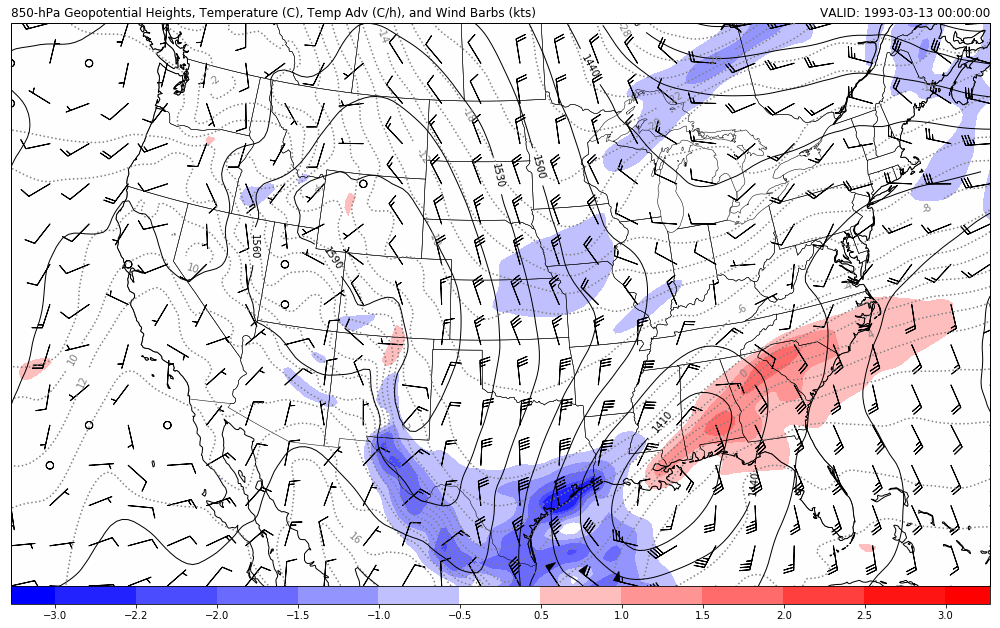

In [16]:
fig, ax = create_map_background()

# Contour #1
clev850 = np.arange(0,4000,30)
cs2 = ax.contour(lon,lat,tmpk_850.to('degC'),range(-50,50,2),colors='grey',linestyles='dotted',
                 transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

# Contour #2
cs = ax.contour(lon,lat,hght_850,clev850,colors='k',
                linewidths=1.0,linestyles='solid',transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

# Colorfill
cf = ax.contourf(lon,lat,tmpc_adv_850*3600,[-3,-2.2,-2,-1.5,-1,-0.5,0.5,1.0,1.5,2.0,2.5,3.0],
                 cmap='bwr',extend='both',transform=dataproj)
plt.colorbar(cf,orientation='horizontal',pad=0.0,aspect=50,extendrect=True,
             ticks=[-3,-2.2,-2,-1.5,-1,-0.5,0.5,1.0,1.5,2.0,2.5,3.0])

# Vector
ax.barbs(lon,lat,uwnd_850.to('kts').m,vwnd_850.to('kts').m,regrid_shape=15,transform=dataproj)

# Titles
plt.title('850-hPa Geopotential Heights, Temperature (C), Temp Adv (C/h), and Wind Barbs (kts)',loc='left')
plt.title('VALID: %s' %(vtime),loc='right')

plt.tight_layout()
plt.show()

## 500-hPa Absolute Vorticity

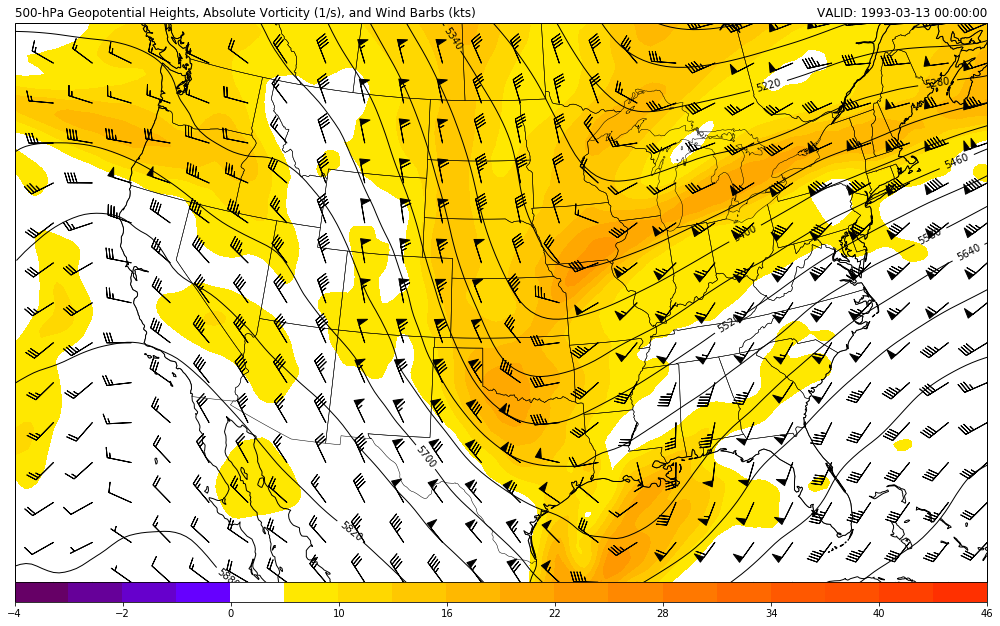

In [17]:
fig, ax = create_map_background()

# Contour #1
clev500 = np.arange(0,7000,60)
cs = ax.contour(lon,lat,hght_500,clev500,colors='k',
                linewidths=1.0,linestyles='solid',transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=4, fmt='%i', rightside_up=True, use_clabeltext=True)

# Colorfill
# Set contour intervals for Absolute Vorticity
clevavor500 = [-4,-3,-2,-1,0,7,10,13,16,19,22,25,28,31,34,37,40,43,46]
# Set colorfill colors for absolute vorticity; purple negative, yellow to orange positive
colorsavor500 = ('#660066', '#660099', '#6600CC', '#6600FF', 'w', '#ffE800', '#ffD800',
                 '#ffC800', '#ffB800', '#ffA800', '#ff9800', '#ff8800', '#ff7800',
                 '#ff6800', '#ff5800', '#ff5000', '#ff4000', '#ff3000')
cf = ax.contourf(lon,lat,avor_500*10**5,clevavor500,colors=colorsavor500,transform=dataproj)
plt.colorbar(cf,orientation='horizontal',pad=0.0,aspect=50)

# Vector
ax.barbs(lon,lat,uwnd_500.to('kts').m,vwnd_500.to('kts').m,regrid_shape=15,transform=dataproj)

# Titles
plt.title('500-hPa Geopotential Heights, Absolute Vorticity (1/s), and Wind Barbs (kts)',loc='left')
plt.title('VALID: %s' %(vtime),loc='right')

plt.tight_layout()
plt.show()

## 300-hPa Wind Speed, Divergence, and Ageostrophic Wind

/Users/kgoebber/miniconda3/lib/python3.6/site-packages/cartopy/vector_transform.py:131: RuntimeWarning: invalid value encountered in less
  u, v = target_proj.transform_vectors(src_crs, x, y, u, v)
/Users/kgoebber/miniconda3/lib/python3.6/site-packages/cartopy/vector_transform.py:131: RuntimeWarning: invalid value encountered in greater
  u, v = target_proj.transform_vectors(src_crs, x, y, u, v)


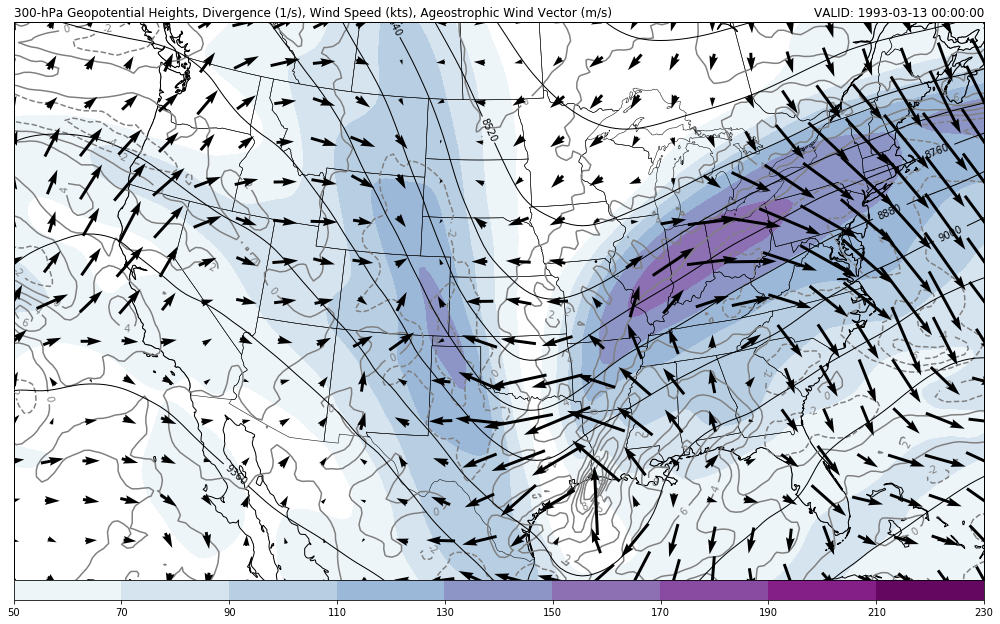

In [18]:
fig, ax = create_map_background()

# Contour #1
clev300 = np.arange(0,11000,120)
cs2 = ax.contour(lon,lat,div_300*10**5,range(-10,11,2),colors='grey',transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=4, fmt='%i', rightside_up=True, use_clabeltext=True)

# Contour #2
cs = ax.contour(lon,lat,hght_300,clev300,colors='k',
                linewidths=1.0,linestyles='solid',transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=4, fmt='%i', rightside_up=True, use_clabeltext=True)

# Colorfill
spd300 = np.arange(50,250,20)
cf = ax.contourf(lon,lat,wspd_300,spd300,cmap='BuPu',transform=dataproj,zorder=0)
plt.colorbar(cf, orientation='horizontal',pad=0.0,aspect=50)

# Vector
ax.quiver(lon,lat,uageo_300.m,vageo_300.m,regrid_shape=15,pivot='mid',transform=dataproj,zorder=10)

# Titles
plt.title('300-hPa Geopotential Heights, Divergence (1/s), Wind Speed (kts), Ageostrophic Wind Vector (m/s)',
          loc='left')
plt.title('VALID: %s' %(vtime),loc='right')

plt.tight_layout()
plt.show()

## Vorticity Tendency Terms

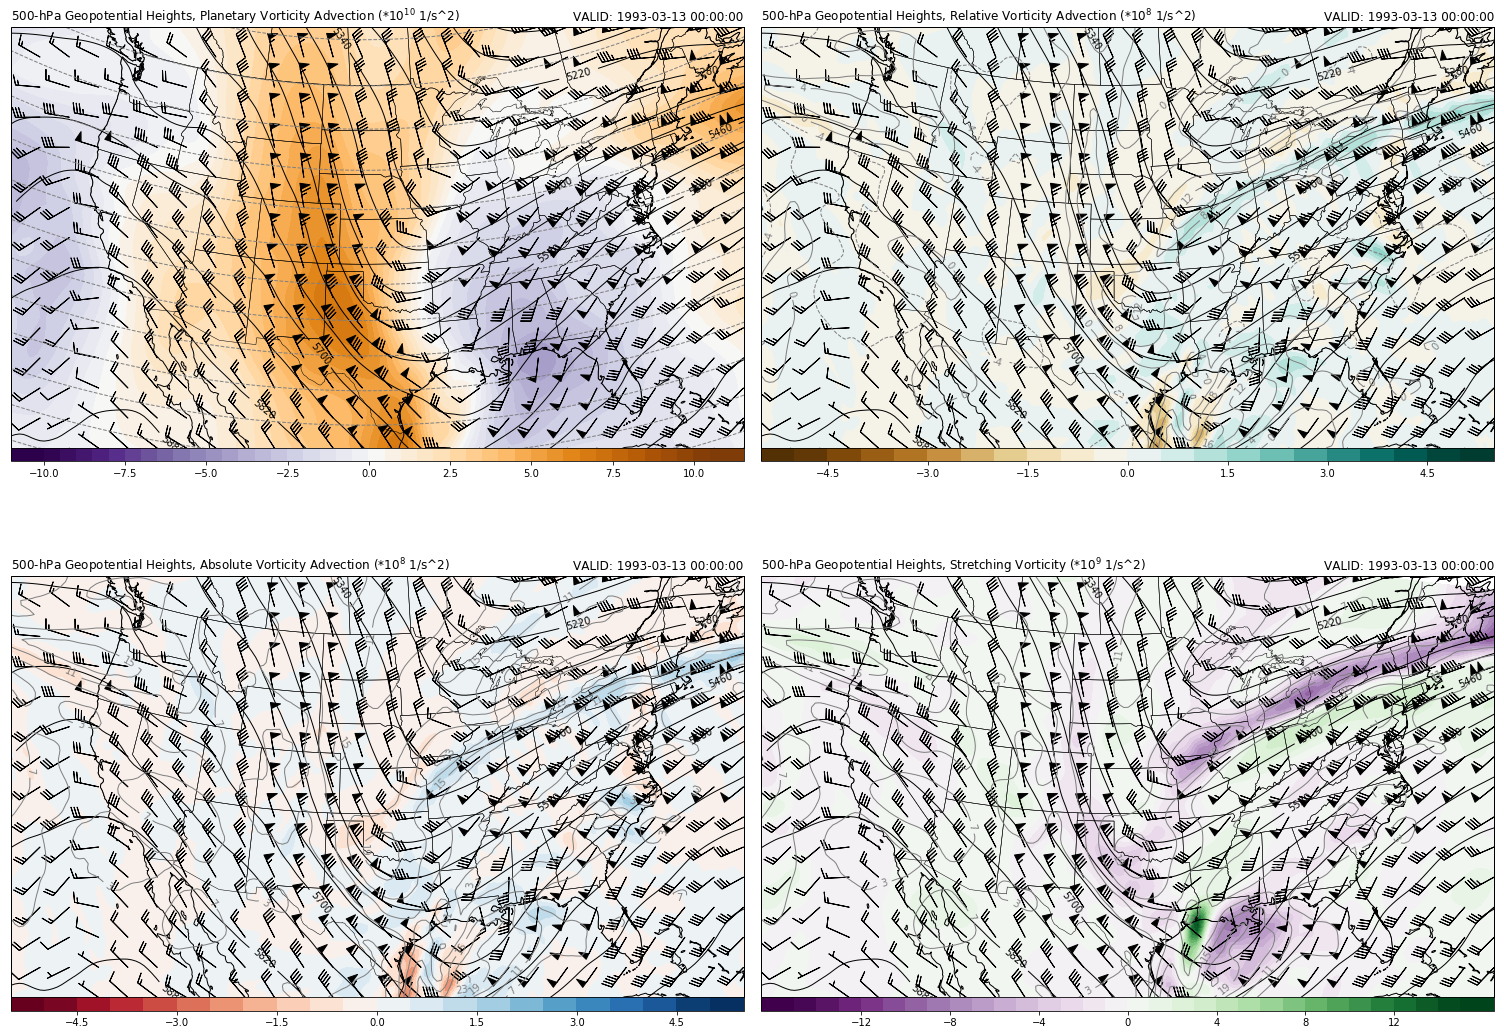

In [19]:
fig=plt.figure(1,figsize=(21.,16.))

# Upper-Left Panel
ax=plt.subplot(221,projection=plotproj)
ax.set_extent([-125.,-73,25.,50.],ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)

# Contour #1
clev500 = np.arange(0,7000,60)
cs = ax.contour(lon,lat,hght_500,clev500,colors='k',
                linewidths=1.0,linestyles='solid',transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i', rightside_up=True, use_clabeltext=True)

# Contour #2
cs2 = ax.contour(lon,lat,f*10**4,np.arange(0,3,.05),colors='grey',
                linewidths=1.0,linestyles='dashed',transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%.2f', rightside_up=True, use_clabeltext=True)

# Colorfill
cf = ax.contourf(lon,lat,f_adv*10**10,np.arange(-10,11,0.5),
                 cmap='PuOr_r',extend='both',transform=dataproj)
plt.colorbar(cf, orientation='horizontal',pad=0.0,aspect=50,extendrect=True)

# Vector
ax.barbs(lon,lat,uwnd_500.to('kts').m,vwnd_500.to('kts').m,regrid_shape=15,transform=dataproj)

# Titles
plt.title(r'500-hPa Geopotential Heights, Planetary Vorticity Advection ($*10^{10}$ 1/s^2)',loc='left')
plt.title('VALID: %s' %(vtime),loc='right')



# Upper-Right Panel
ax=plt.subplot(222,projection=plotproj)
ax.set_extent([-125.,-73,25.,50.],ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)

# Contour #1
clev500 = np.arange(0,7000,60)
cs = ax.contour(lon,lat,hght_500,clev500,colors='k',
                linewidths=1.0,linestyles='solid',transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i', rightside_up=True, use_clabeltext=True)

# Contour #2
cs2 = ax.contour(lon,lat,vor_500*10**5,np.arange(-40,41,4),colors='grey',
                linewidths=1.0,transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d', rightside_up=True, use_clabeltext=True)

# Colorfill
cf = ax.contourf(lon,lat,relvort_adv*10**8,np.arange(-5,5.5,0.5),
                 cmap='BrBG',extend='both',transform=dataproj)
plt.colorbar(cf, orientation='horizontal',pad=0.0,aspect=50,extendrect=True)

# Vector
ax.barbs(lon,lat,uwnd_500.to('kts').m,vwnd_500.to('kts').m,regrid_shape=15,transform=dataproj)

# Titles
plt.title(r'500-hPa Geopotential Heights, Relative Vorticity Advection ($*10^{8}$ 1/s^2)',loc='left')
plt.title('VALID: %s' %(vtime),loc='right')



# Lower-Left Panel
ax=plt.subplot(223,projection=plotproj)
ax.set_extent([-125.,-73,25.,50.],ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)

# Contour #1
clev500 = np.arange(0,7000,60)
cs = ax.contour(lon,lat,hght_500,clev500,colors='k',
                linewidths=1.0,linestyles='solid',transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i', rightside_up=True, use_clabeltext=True)

# Contour #2
cs2 = ax.contour(lon,lat,avor_500*10**5,np.arange(-5,41,4),colors='grey',
                linewidths=1.0,transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d', rightside_up=True, use_clabeltext=True)

# Colorfill
cf = ax.contourf(lon,lat,absvort_adv*10**8,np.arange(-5,5.5,0.5),
                 cmap='RdBu',extend='both',transform=dataproj)
plt.colorbar(cf, orientation='horizontal',pad=0.0,aspect=50,extendrect=True)

# Vector
ax.barbs(lon,lat,uwnd_500.to('kts').m,vwnd_500.to('kts').m,regrid_shape=15,transform=dataproj)

# Titles
plt.title(r'500-hPa Geopotential Heights, Absolute Vorticity Advection ($*10^{8}$ 1/s^2)',loc='left')
plt.title('VALID: %s' %(vtime),loc='right')



# Lower-Right Panel
ax=plt.subplot(224,projection=plotproj)
ax.set_extent([-125.,-73,25.,50.],ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)

# Contour #1
clev500 = np.arange(0,7000,60)
cs = ax.contour(lon,lat,hght_500,clev500,colors='k',
                linewidths=1.0,linestyles='solid',transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i', rightside_up=True, use_clabeltext=True)

# Contour #2
cs2 = ax.contour(lon,lat,gaussian_filter(avor_500*10**5,sigma=1.0),np.arange(-5,41,4),colors='grey',
                linewidths=1.0,transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d', rightside_up=True, use_clabeltext=True)

# Colorfill
cf = ax.contourf(lon,lat,gaussian_filter(stretch_vort*10**9,sigma=1.0),np.arange(-15,16,1),
                 cmap='PRGn',extend='both',transform=dataproj)
plt.colorbar(cf, orientation='horizontal',pad=0.0,aspect=50,extendrect=True)

# Vector
ax.barbs(lon,lat,uwnd_500.to('kts').m,vwnd_500.to('kts').m,regrid_shape=15,transform=dataproj)

# Titles
plt.title(r'500-hPa Geopotential Heights, Stretching Vorticity ($*10^{9}$ 1/s^2)',loc='left')
plt.title('VALID: %s' %(vtime),loc='right')

plt.tight_layout()
plt.show()

## Plotting Data for Hand Calculation



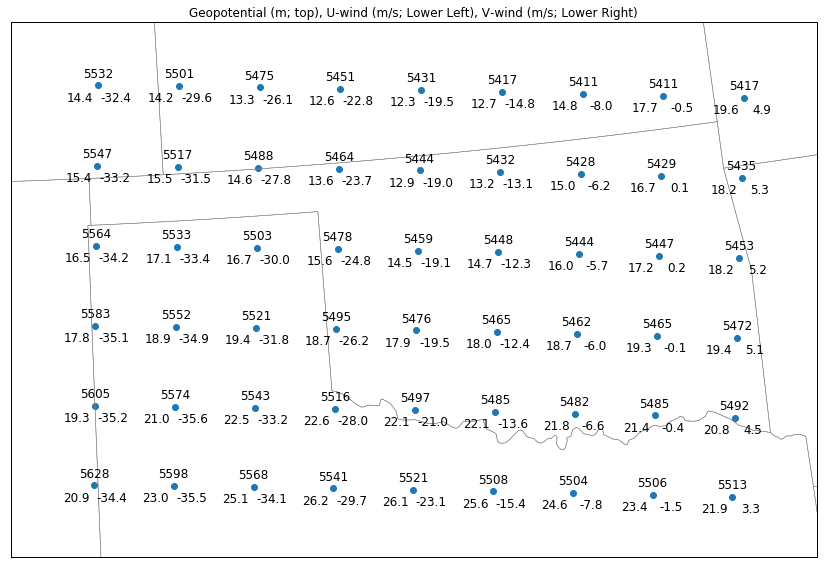

In [20]:
# Set lat/lon bounds for region to plot data
LLlon = -104
LLlat = 33
URlon = -94
URlat = 38

# Set up mask so that you only plot what you want
mask_lon = ((lon[::3,::3].ravel() > LLlon+0.05) & (lon[::3,::3].ravel() < URlon+0.01))
mask_lat = ((lat[::3,::3].ravel() < URlat-0.01) & (lat[::3,::3].ravel() > LLlat-0.01))
mask = mask_lon&mask_lat


# Set up plot basics and use StationPlot class from MetPy to help with plotting
fig = plt.figure(figsize=(14,8))
ax = plt.subplot(111,projection=ccrs.LambertConformal(central_latitude=50,central_longitude=-107))
ax.set_extent([LLlon,URlon,LLlat,URlat],ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='grey',linewidth=0.75)
ax.add_feature(states_provinces,edgecolor='grey',linewidth=0.5)

# Set up station plotting using only every third element from arrays for plotting
stationplot = StationPlot(ax, lon[::3,::3].ravel()[mask], lat[::3,::3].ravel()[mask],
                          transform=ccrs.PlateCarree(), fontsize=12)

# Plot markers then data around marker for calculation purposes
ax.scatter(lon[::3,::3].ravel()[mask],lat[::3,::3].ravel()[mask],marker='o',transform=dataproj)
stationplot.plot_parameter((0,1), hght_500[::3,::3].m.ravel()[mask])
stationplot.plot_parameter((-1.5,-1), uwnd_500[::3,::3].m.ravel()[mask], formatter='.1f')
stationplot.plot_parameter((1.5,-1), vwnd_500[::3,::3].m.ravel()[mask], formatter='.1f')

# Title
plt.title('Geopotential (m; top), U-wind (m/s; Lower Left), V-wind (m/s; Lower Right)')

plt.tight_layout()
plt.show()